In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from align_faces import warp_and_crop_face, get_reference_facial_points

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
from tqdm import tqdm
import random
import os
from torchmetrics import F1Score

import time

In [4]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
train_dir_path = '../input/data/train/'
train_image_path = '../input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
exp_train = pd.read_csv(train_dir_path+'expanded_train.csv')

def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))
dt_train

,id,gender,race,age,path,age_range
0,000001,female,Asian,45,000001_female_Asian_45,1
1,000002,female,Asian,52,000002_female_Asian_52,1
2,000004,male,Asian,54,000004_male_Asian_54,1
3,000005,female,Asian,58,000005_female_Asian_58,1
4,000006,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,0
2696,006955,male,Asian,19,006955_male_Asian_19,0
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0


In [6]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])
dt_train.iloc[train_idx].head(70)

,id,gender,race,age,path,age_range
49,000077,male,Asian,59,000077_male_Asian_59,1
2141,005420,female,Asian,48,005420_female_Asian_48,1
2029,005106,female,Asian,54,005106_female_Asian_54,1
574,001217,female,Asian,25,001217_female_Asian_25,0
2188,005478,female,Asian,43,005478_female_Asian_43,1
...,...,...,...,...,...,...
936,001723,female,Asian,35,001723_female_Asian_35,1
1570,003724,female,Asian,58,003724_female_Asian_58,1
1624,003791,female,Asian,50,003791_female_Asian_50,1
1643,003813,male,Asian,51,003813_male_Asian_51,1


In [7]:
# train_image = []
# train_label = []

# for idx in train_idx:
#     path = dt_train.iloc[idx]['path']
#     for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
#         _, file_extension = os.path.splitext(file_name)
#         if file_extension not in ['.jpg', '.jpeg', '.png']:
#             continue
#         train_image.append(train_image_path+path+'/'+file_name)
#         train_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))                                 

In [8]:
# valid_image = []
# valid_label = []

# for idx in valid_idx:
#     path = dt_train.iloc[idx]['path']
#     for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
#         _, file_extension = os.path.splitext(file_name)
#         if file_extension not in ['.jpg', '.jpeg', '.png']:
#             continue
#         valid_image.append(train_image_path+path+'/'+file_name)
#         valid_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0])) 

In [9]:
split_exp_train = exp_train[exp_train['PersonID'].isin(list(dt_train.iloc[train_idx]["id"]))]
split_exp_valid = exp_train[exp_train['PersonID'].isin(list(dt_train.iloc[valid_idx]["id"]))]
print(f"index size: {len(train_idx)} == file estimate: {len(train_idx) * 7} == split size: {len(split_exp_train)}")
split_exp_train

index size: 2160 == file estimate: 15120 == split size: 15127


,Unnamed: 0,PersonID,Filename,Class,Mask,Gender,Age,Age_Class,Has_Face,BBoxX1,...,LE_X,LE_Y,RE_X,RE_Y,N_X,N_Y,LM_X,LM_Y,RM_X,RM_Y
0,0,000001,../input/data/train/images/000001_female_Asian...,10,1,1,45,1,True,122,...,152,205,211,202,182,245,164,275,205,273
1,1,000001,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,True,110,...,139,232,209,234,171,275,151,307,194,309
2,2,000001,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,True,112,...,145,230,206,230,176,268,158,296,198,297
3,3,000001,../input/data/train/images/000001_female_Asian...,16,2,1,45,1,True,126,...,154,223,213,219,184,260,164,288,213,284
4,4,000001,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,True,120,...,150,223,210,219,182,257,165,289,204,287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18888,18888,006957,../input/data/train/images/006957_male_Asian_2...,0,0,0,20,0,True,110,...,150,226,223,222,190,270,164,306,217,302
18889,18889,006957,../input/data/train/images/006957_male_Asian_2...,12,2,0,20,0,True,103,...,142,227,212,223,178,267,154,310,210,307
18890,18890,006957,../input/data/train/images/006957_male_Asian_2...,0,0,0,20,0,True,94,...,137,225,209,225,178,267,151,303,202,303
18891,18891,006957,../input/data/train/images/006957_male_Asian_2...,0,0,0,20,0,True,103,...,144,220,219,217,185,269,159,304,212,302


In [10]:
train_image = split_exp_train.loc[:,"Filename"]
train_label = split_exp_train.loc[:,"Class"]

valid_image = split_exp_valid.loc[:,"Filename"]
valid_label = split_exp_valid.loc[:,"Class"]

In [11]:
train_image[0]

'../input/data/train/images/000001_female_Asian_45/incorrect_mask.npy'

In [12]:
# train_image = train_image.apply(lambda x : x[:-4])
# valid_image = valid_image.apply(lambda x : x[:-4])

In [13]:
print(len(train_image))
print(len(valid_image))

15127
3787


In [14]:
train_data = pd.Series(train_image)
train_label = pd.Series(train_label)

valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [15]:
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, CenterCrop, ColorJitter
from PIL import Image

default_square = True
inner_padding_factor = 0.25 #0.2~0.3
outer_padding = (0, 0)
#output_size = (224, 224)
output_size = (384, 384)

class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None, is_train=True):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data.reset_index(drop=True)
        self.is_train = is_train
        self.label = label.reset_index(drop=True)
        self.transform = transform

        """
        self.images = list()
        for idx in range(len(self.data)):
            img_raw = np.load(self.data[idx])
        
            # X = X[64:448]
            source_df = split_exp_train if self.is_train else split_exp_valid
            facial5points = [[source_df.iloc[idx]['LE_X'], source_df.iloc[idx]['LE_Y']],
                             [source_df.iloc[idx]['RE_X'], source_df.iloc[idx]['RE_Y']],
                             [source_df.iloc[idx][ 'N_X'], source_df.iloc[idx][ 'N_Y']],
                             [source_df.iloc[idx]['LM_X'], source_df.iloc[idx]['LM_Y']],
                             [source_df.iloc[idx]['RM_X'], source_df.iloc[idx]['RM_Y']]]
            reference_5pts = get_reference_facial_points(output_size, inner_padding_factor, outer_padding, default_square)
            align_crop_img = warp_and_crop_face(img_raw, facial5points, reference_pts=reference_5pts, crop_size=output_size)

            self.images.append(align_crop_img)
        """
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        #img_raw = np.load(self.data[idx])
        filepath = self.data[idx]
        if os.path.exists(filepath) == False:
            filename, _ = os.path.splitext(filepath)
            for extension in ['.jpg', '.jpeg', '.png']:
                if os.path.exists(filename + extension) == True:
                    filepath = filename + extension
        #print(filepath)
        img_raw = cv2.cvtColor(cv2.imread(filepath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        
        # X = X[64:448]
        source_df = split_exp_train if self.is_train else split_exp_valid
        facial5points = [[source_df.iloc[idx]['LE_X'], source_df.iloc[idx]['LE_Y']],
                         [source_df.iloc[idx]['RE_X'], source_df.iloc[idx]['RE_Y']],
                         [source_df.iloc[idx][ 'N_X'], source_df.iloc[idx][ 'N_Y']],
                         [source_df.iloc[idx]['LM_X'], source_df.iloc[idx]['LM_Y']],
                         [source_df.iloc[idx]['RM_X'], source_df.iloc[idx]['RM_Y']]]
        reference_5pts = get_reference_facial_points(output_size, inner_padding_factor, outer_padding, default_square)
        X = warp_and_crop_face(img_raw, facial5points, reference_pts=reference_5pts, crop_size=output_size)
        y = self.label[idx]
        
        if self.transform:
            return self.transform(X), y

        return X, y

In [16]:
mask_train_set = Dataset_Mask(data=train_data, label=train_label, is_train=True, transform=transforms.Compose([
                                    ToTensor(),
                                    #Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ]))

In [17]:
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, is_train=False, transform = transforms.Compose([
                                    ToTensor(),
                                    #Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ]))

In [18]:
#t_image = [mask_train_set[i][1] for i in tqdm(range(len(mask_train_set)))]
#v_image = [mask_val_set[i][1] for i in tqdm(range(len(mask_val_set)))]

In [19]:
#t_df = pd.DataFrame(t_image, columns=['counts'])
#v_df = pd.DataFrame(v_image, columns=['counts'])

In [20]:
#import seaborn as sns

#fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#sns.countplot(x='counts', data=t_df, ax=axes[0])
#axes[0].set_xlabel("train set labels")
#sns.countplot(x='counts', data=v_df, ax=axes[1])
#axes[1].set_xlabel("valid set labels")

In [21]:
#print(f'training data size : {len(mask_train_set)}')
#print(f'validation data size : {len(mask_val_set)}')

In [22]:
batch_size = 64

train_dataloader_mask = DataLoader(dataset = mask_train_set, batch_size=batch_size, num_workers=2)
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, num_workers=2)

In [23]:
model = torchvision.models.resnet50(pretrained=True)
print('필요 입력 채널 개수', model.conv1.weight.shape[1])
print('네트워크 출력 채널 개수', model.fc.weight.shape[0])
print(model)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


필요 입력 채널 개수 3
네트워크 출력 채널 개수 1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

In [24]:
import math
class_num = 18
model.fc = nn.Linear(in_features=2048, out_features=class_num, bias=True)
nn.init.xavier_uniform_(model.fc.weight)
stdv = 1. / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

print('필요 입력 채널 개수', model.conv1.weight.shape[1])
print('네트워크 출력 채널 개수', model.fc.weight.shape[0])

필요 입력 채널 개수 3
네트워크 출력 채널 개수 18


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

model = torch.nn.DataParallel(model)
model.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#lr = 1e-3
#betas = (0.9, 0.999)
#weight_decay = 0.5e-4
#eps = 1e-8
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)

using cuda:0


In [26]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(model.named_parameters()):
    if param.requires_grad:
        
        #if param_name.startswith('module.fc') or param_name.startswith('module.layer4') or param_name.startswith('module.layer3'):
        #    param.requires_grad = True  # Train
        #else:
        #    param.requires_grad = False # Freeze
            
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
        print(f"    --[{param.requires_grad}].")
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[module.conv1.weight] shape:[(64, 3, 7, 7)].
    val:[ 0.013  0.015 -0.015 -0.023 -0.041]
    --[True].
[1] name:[module.bn1.weight] shape:[(64,)].
    val:[0.239 0.291 0.316 0.271 0.217]
    --[True].
[2] name:[module.bn1.bias] shape:[(64,)].
    val:[0.225 0.606 0.012 0.133 0.18 ]
    --[True].
[3] name:[module.layer1.0.conv1.weight] shape:[(64, 64, 1, 1)].
    val:[ 0.004  0.04  -0.025 -0.028  0.089]
    --[True].
[4] name:[module.layer1.0.bn1.weight] shape:[(64,)].
    val:[0.213 0.188 0.141 0.153 0.132]
    --[True].
[5] name:[module.layer1.0.bn1.bias] shape:[(64,)].
    val:[ 0.433  0.047 -0.08   0.073  0.28 ]
    --[True].
[6] name:[module.layer1.0.conv2.weight] shape:[(64, 64, 3, 3)].
    val:[ 2.092e-09 -1.415e-09  6.585e-09  4.792e-09  3.282e-09]
    --[True].
[7] name:[module.layer1.0.bn2.weight] shape:[(64,)].
    val:[2.322e-08 1.381e-01 2.416e-01 1.363e-01 1.158e-01]
    --[True].
[8] name:[module.layer1.0.bn2.bias] shape:[(64,)].
    val:[-1.165e-07  3.803e-02  

In [27]:
best_val_acc = 0
best_val_loss = np.inf
patience = 10
cur_count = 0

f1 = F1Score(num_classes=class_num, average='macro').to(device)
best_f1_score = 0

import matplotlib.pyplot as plt

for epoch in range(NUM_EPOCH):
    model.train()
    loss_value = 0
    matches = 0
    for train_batch in train_dataloader_mask:
        
        inputs, labels = train_batch
        
        
#         plt.imshow(transforms.ToPILImage()(inputs[0]))
#         plt.show()
#         continue
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0:
            torch.save(model, '../checkpoint/resnet50_detection/checkpoint_ep_%d.pth'% epoch)
        
        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        
        train_loss = loss_value / batch_size
        train_acc = matches / batch_size
        
        loss_value = 0
        matches = 0
    print(f"epoch[{epoch}/{NUM_EPOCH}] training loss {train_loss:.3f}, training accuracy {train_acc:.3f}")
    time.sleep(0.5)
    
    with torch.no_grad():
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in tqdm(val_dataloader_mask):
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)
            
            loss_item = criterion(outs, labels).item()
            acc_item = (labels==preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_dataloader_mask)
        val_acc = np.sum(val_acc_items) / len(mask_val_set)

        f1_score = f1(outs, labels)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            cur_count = 0
            torch.save(model, '../checkpoint/resnet50_detection/checkpoint_best.pth')
            print("Update checkpoint!!!")
        
        else:
            cur_count += 1
            if cur_count >= patience:
                print("Early Stopping!")
                break
            
            
        print(f"[val] acc : {val_acc:.3f}, loss : {val_loss:.3f}, f1 score: {f1_score:.3f} -- size({len(val_dataloader_mask)})")
        print(f"best acc : {best_val_acc:.3f}, best loss : {best_val_loss:.3f}, best f1 : {best_f1_score:.3f}")

epoch[0/50] training loss 0.001, training accuracy 0.359


100%|██████████| 60/60 [00:19<00:00,  3.03it/s]


Update checkpoint!!!
[val] acc : 0.289, loss : 2.558, f1 score: 0.647 -- size(60)
best acc : 0.289, best loss : 2.558, best f1 : 0.647
epoch[1/50] training loss 0.002, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.68it/s]


Update checkpoint!!!
[val] acc : 0.417, loss : 1.821, f1 score: 1.000 -- size(60)
best acc : 0.417, best loss : 1.821, best f1 : 1.000
epoch[2/50] training loss 0.001, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.74it/s]

[val] acc : 0.511, loss : 1.481, f1 score: 1.000 -- size(60)
best acc : 0.511, best loss : 1.481, best f1 : 1.000


epoch[3/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.56it/s]

[val] acc : 0.686, loss : 0.945, f1 score: 1.000 -- size(60)
best acc : 0.686, best loss : 0.945, best f1 : 1.000


epoch[4/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.63it/s]

[val] acc : 0.668, loss : 1.100, f1 score: 1.000 -- size(60)
best acc : 0.686, best loss : 0.945, best f1 : 1.000


epoch[5/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.34it/s]

[val] acc : 0.602, loss : 1.379, f1 score: 1.000 -- size(60)
best acc : 0.686, best loss : 0.945, best f1 : 1.000


epoch[6/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.61it/s]

[val] acc : 0.687, loss : 1.165, f1 score: 1.000 -- size(60)
best acc : 0.687, best loss : 0.945, best f1 : 1.000


epoch[7/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.45it/s]

[val] acc : 0.784, loss : 0.990, f1 score: 1.000 -- size(60)
best acc : 0.784, best loss : 0.945, best f1 : 1.000


epoch[8/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.51it/s]

[val] acc : 0.838, loss : 0.676, f1 score: 1.000 -- size(60)
best acc : 0.838, best loss : 0.676, best f1 : 1.000


epoch[9/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.57it/s]

[val] acc : 0.833, loss : 0.666, f1 score: 1.000 -- size(60)
best acc : 0.838, best loss : 0.666, best f1 : 1.000


epoch[10/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.46it/s]

[val] acc : 0.850, loss : 0.645, f1 score: 1.000 -- size(60)
best acc : 0.850, best loss : 0.645, best f1 : 1.000


epoch[11/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.26it/s]

[val] acc : 0.866, loss : 0.697, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[12/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.57it/s]

[val] acc : 0.796, loss : 1.156, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[13/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.30it/s]

[val] acc : 0.843, loss : 0.671, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[14/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.62it/s]

[val] acc : 0.834, loss : 1.933, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[15/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.70it/s]

[val] acc : 0.835, loss : 0.944, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[16/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]

[val] acc : 0.857, loss : 1.014, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[17/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]

[val] acc : 0.841, loss : 1.057, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[18/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.49it/s]

[val] acc : 0.848, loss : 0.825, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[19/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]

[val] acc : 0.846, loss : 0.800, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[20/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.54it/s]

[val] acc : 0.863, loss : 0.734, f1 score: 1.000 -- size(60)
best acc : 0.866, best loss : 0.645, best f1 : 1.000


epoch[21/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.38it/s]

[val] acc : 0.882, loss : 0.640, f1 score: 1.000 -- size(60)
best acc : 0.882, best loss : 0.640, best f1 : 1.000


epoch[22/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.55it/s]

[val] acc : 0.881, loss : 0.649, f1 score: 1.000 -- size(60)
best acc : 0.882, best loss : 0.640, best f1 : 1.000


epoch[23/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.39it/s]

[val] acc : 0.881, loss : 0.655, f1 score: 1.000 -- size(60)
best acc : 0.882, best loss : 0.640, best f1 : 1.000


epoch[24/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.49it/s]

[val] acc : 0.890, loss : 0.594, f1 score: 1.000 -- size(60)
best acc : 0.890, best loss : 0.594, best f1 : 1.000


epoch[25/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.42it/s]

[val] acc : 0.890, loss : 0.594, f1 score: 1.000 -- size(60)
best acc : 0.890, best loss : 0.594, best f1 : 1.000


epoch[26/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:15<00:00,  3.75it/s]

[val] acc : 0.891, loss : 0.595, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[27/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.45it/s]

[val] acc : 0.891, loss : 0.598, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[28/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.53it/s]

[val] acc : 0.891, loss : 0.600, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[29/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.33it/s]

[val] acc : 0.890, loss : 0.602, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[30/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.40it/s]

[val] acc : 0.890, loss : 0.605, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[31/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.30it/s]

[val] acc : 0.890, loss : 0.607, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[32/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.64it/s]

[val] acc : 0.890, loss : 0.609, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[33/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.38it/s]

[val] acc : 0.890, loss : 0.612, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[34/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.44it/s]

[val] acc : 0.891, loss : 0.614, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[35/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.37it/s]

[val] acc : 0.890, loss : 0.617, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[36/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]

[val] acc : 0.891, loss : 0.619, f1 score: 1.000 -- size(60)
best acc : 0.891, best loss : 0.594, best f1 : 1.000


epoch[37/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.40it/s]

[val] acc : 0.892, loss : 0.622, f1 score: 1.000 -- size(60)
best acc : 0.892, best loss : 0.594, best f1 : 1.000


epoch[38/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.42it/s]

[val] acc : 0.892, loss : 0.624, f1 score: 1.000 -- size(60)
best acc : 0.892, best loss : 0.594, best f1 : 1.000


epoch[39/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.65it/s]

[val] acc : 0.892, loss : 0.626, f1 score: 1.000 -- size(60)
best acc : 0.892, best loss : 0.594, best f1 : 1.000


epoch[40/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.49it/s]

[val] acc : 0.892, loss : 0.629, f1 score: 1.000 -- size(60)
best acc : 0.892, best loss : 0.594, best f1 : 1.000


epoch[41/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.53it/s]

[val] acc : 0.892, loss : 0.631, f1 score: 1.000 -- size(60)
best acc : 0.892, best loss : 0.594, best f1 : 1.000


epoch[42/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:19<00:00,  3.02it/s]

[val] acc : 0.893, loss : 0.634, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[43/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.32it/s]

[val] acc : 0.892, loss : 0.636, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[44/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]

[val] acc : 0.892, loss : 0.639, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[45/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:19<00:00,  3.11it/s]

[val] acc : 0.892, loss : 0.641, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[46/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]

[val] acc : 0.893, loss : 0.644, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[47/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:16<00:00,  3.54it/s]

[val] acc : 0.892, loss : 0.647, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[48/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:17<00:00,  3.34it/s]

[val] acc : 0.892, loss : 0.649, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


epoch[49/50] training loss 0.000, training accuracy 0.359


100%|██████████| 60/60 [00:18<00:00,  3.31it/s]

[val] acc : 0.892, loss : 0.652, f1 score: 1.000 -- size(60)
best acc : 0.893, best loss : 0.594, best f1 : 1.000


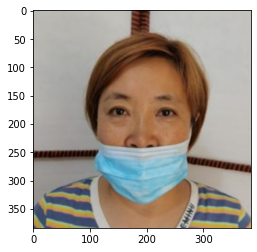

In [34]:
for train_batch in train_dataloader_mask:
    inputs, labels = train_batch
    plt.imshow(transforms.ToPILImage()(inputs[0]))
    plt.show()
    break

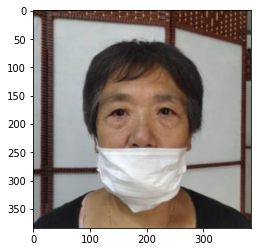

In [35]:
for val_batch in val_dataloader_mask:
    inputs, labels = val_batch
    plt.imshow(transforms.ToPILImage()(inputs[0]))
    plt.show()
    break